In [1]:
import uuid

from langchain.embeddings import OpenAIEmbeddings

from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI

from langchain.retrievers import ParentDocumentRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.prompts import (ChatPromptTemplate,SystemMessagePromptTemplate,HumanMessagePromptTemplate , PromptTemplate)

from langchain.storage import InMemoryStore

from langchain.chains import RetrievalQA



/Users/altaf/Projects/LLM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
loader = PyPDFLoader('../Docs/annualreport.pdf')

In [3]:
docs = loader.load()

In [14]:
pages = loader.load_and_split()

DependencyError: PyCryptodome is required for AES algorithm

In [4]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="split_parents", embedding_function=OpenAIEmbeddings())
# The storage layer for the parent documents
store = InMemoryStore()

In [5]:
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [7]:
retriever.add_documents(documents=docs , ids = None)

In [8]:
len(list(store.yield_keys()))

662

In [9]:
sub_docs = vectorstore.similarity_search("Net Profit, Expenses, Profit before tax and Net income")
print(sub_docs[0].page_content)

Net operating income  17,324 12,774 12,325 12,754 10,920 10,364 10,158 9,262 8,132 6,657
Total operating expenses (10,785) (8,867) (8,871) (8,887) (7,456) (7,260) (7,143) (6,740) (6,026) (5,252)
Operating profit before income tax  6,539 3,907 3,454 3,867 3,464 3,104 3,015 2,522 2,106 1,405
Income tax expense  (1,586) (899) (728) (879) (883) (868) (927) (899) (827) (533)


In [10]:
retrieved_docs = retriever.get_relevant_documents("Net Profit, Expenses, Profit before tax and Net income")

print(len(retrieved_docs))

print(len(retrieved_docs[0].page_content))

print(retrieved_docs[2].page_content)

4
1979
199Macquarie Group Limited and its subsidiaries 2022 Annual ReportFurther Information Directors’ Report Governance About Financial Report
Note 29 
Notes to the statements of cash flows continued
CONSOLIDATED COMPANY
2022 2021 2022 2021
$m $m $m $m
(ii) Reconciliation of profit after income tax to net cash flows generated from/(utilised in) operating activities
Profit after income tax  4,953 3,008 1,549 755
Adjustments to profit after income tax:
Depreciation and amortisation  819 925 – –
Expected credit losses and other impairment charges  509 524 17 (18)
Reversal of impairment on investment in subsidiary – – (1,896) –
Investment income and gain on sale of operating lease assets and other 
non-financial assets  (3,257) (1,968) – (167)
Share-based payments expense  618 529 – –
Share of net (profits)/losses of associates and joint ventures  (240) 3 – –
Changes in assets and liabilities:
Issued debt securities  38,526 4,138 12,542 2,288
Deposits  17,465 17,179 (11) (5)
Trading, tra

In [11]:
template="You are an experienced financial analyst who use the data provided --- {Data}. \
    To answer the questions from the user. If you cannot answer the question from the data provided, \
        just say so and do not attempt to answer."

system_message_prompt = SystemMessagePromptTemplate.from_template(template)
human_template="{Question}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

prompt_template = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])

In [19]:
qdocs = "".join([retrieved_docs[i].page_content for i in range(len(retrieved_docs))])

In [12]:
chat_input = prompt_template.format_messages(
    Data = qdocs,
    Question = "What is the Gross Revenue, Operating Expenses, Profit before tax and Net income for the past 3 years?"
)

NameError: name 'qdocs' is not defined

In [9]:
chat = ChatOpenAI(temperature = 0.0, model_name="gpt-3.5-turbo-16k-0613")

In [25]:
response = chat(chat_input)

In [27]:
print(response.content)

The net profit for Macquarie Group Limited for the financial years ended 31 March 2013-2022 are as follows:

2022: $4,706 million
2021: $3,015 million
2020: $2,731 million
2019: $2,982 million
2018: $2,557 million
2017: $2,217 million
2016: $2,063 million
2015: $1,604 million
2014: $1,265 million
2013: $851 million

The trend in net profit shows an overall increase over the 10-year period, with some fluctuations. There is a general upward trend from 2013 to 2019, with a peak in 2019. However, there was a slight decrease in net profit in 2020, followed by a significant increase in 2021 and 2022. Overall, the trend indicates growth in net profit for Macquarie Group Limited.


In [16]:
prompt_template = """You are an expert financial analyst. Use the following pieces of context to answer the question at the end. \
    If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)


chain_type_kwargs = {"prompt": PROMPT}

In [17]:
qa_chain = RetrievalQA.from_chain_type(
    llm=chat, 
    chain_type="stuff", 
    retriever=retriever, 
    chain_type_kwargs=chain_type_kwargs,
    verbose=True
    )

In [23]:
query = "What is the Gross Income, Operating Expenses, Tax Paid and Net Income for the past 3 years?"

res = qa_chain.run(query)

print(res)



> Entering new RetrievalQA chain...

> Finished chain.
Based on the provided information, the Gross Income, Operating Expenses, Tax Paid, and Net Income for the past 3 years are as follows:

Year 2022:
- Gross Income: $17,324 million
- Operating Expenses: $10,785 million
- Tax Paid: $1,586 million
- Net Income: $4,953 million

Year 2021:
- Gross Income: $12,774 million
- Operating Expenses: $8,867 million
- Tax Paid: $899 million
- Net Income: $3,008 million

Year 2020:
- Gross Income: $12,325 million
- Operating Expenses: $8,871 million
- Tax Paid: $728 million
- Net Income: $2,726 million


In [24]:
from langchain.prompts import ChatPromptTemplate

template = """You are an expert financial analyst. Use the following pieces of context to answer the question at the end. \
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)



In [25]:

from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

In [26]:
#retriever2 = vectorstore.as_retriever()


chain_qa = (
    {
    "context": itemgetter("question") | retriever, 
    "question": itemgetter("question")
} | prompt | chat |StrOutputParser()
)

In [29]:
res = chain_qa.invoke({"question" : "What is the Gross Income, Operating Expenses, Tax Paid and Net Income for the past 3 years?"})

In [30]:
from IPython.display import display,Markdown
display(Markdown(res) )

Based on the provided information, the Gross Income, Operating Expenses, Tax Paid, and Net Income for the past 3 years are as follows:

Year 2022:
- Gross Income: $17,324 million
- Operating Expenses: $10,785 million
- Tax Paid: $1,586 million
- Net Income: $4,953 million

Year 2021:
- Gross Income: $12,774 million
- Operating Expenses: $8,867 million
- Tax Paid: $899 million
- Net Income: $3,008 million

Year 2020:
- Gross Income: $12,325 million
- Operating Expenses: $8,871 million
- Tax Paid: $728 million
- Net Income: $2,726 million

In [14]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List
from operator import itemgetter

from langchain.schema.runnable import RunnablePassthrough

In [11]:

# Define your desired data structure.
class FinanceInfo(BaseModel):
    year: int = Field(description="year")
    gross_income: int = Field(description="gross income")
    operating_expenses: int = Field(description="operating expenses")
    tax_paid: int = Field(description="amount paid as taxes")
    net_income: int = Field(description="net income")



class FinanceInfos(BaseModel):
    FinanceInfos: List[FinanceInfo]

parser = PydanticOutputParser(pydantic_object=FinanceInfos)

In [12]:
from langchain.prompts import ChatPromptTemplate

template = """Use the following pieces of context to answer the question at the end. 

{context}

{format_instructions}

Question: {question}
"""

#template = template + parser.get_format_instructions()


prompt = ChatPromptTemplate.from_template(template)



In [87]:
chain_qa_old = (
    {
    "context": itemgetter("question") | retriever, 
    "format_instructions" : itemgetter("format_instructions"),
    "question": itemgetter("question")
} | prompt | chat | parser
)

res = chain_qa.invoke({"question" : "What is the Gross Income, Operating Expenses, Tax Paid and Net Income for the past 3 years?",\
                       "format_instructions" : parser.get_format_instructions()})

In [15]:
chain_qa = (
    {
    "context": itemgetter("question") | retriever, 
    "format_instructions" : lambda x: parser.get_format_instructions(),
    "question": itemgetter("question")
} | prompt | chat | parser
)



In [16]:
res = chain_qa.invoke({"question" : "What is the Gross Income, Operating Expenses, Tax Paid and Net Income for the past 5 years?"})

In [19]:
res.FinanceInfos

[FinanceInfo(year=2022, gross_income=17324, operating_expenses=10785, tax_paid=1586, net_income=4953),
 FinanceInfo(year=2021, gross_income=12774, operating_expenses=8867, tax_paid=899, net_income=3008),
 FinanceInfo(year=2020, gross_income=12325, operating_expenses=8871, tax_paid=728, net_income=2726),
 FinanceInfo(year=2019, gross_income=12754, operating_expenses=8887, tax_paid=879, net_income=2988),
 FinanceInfo(year=2018, gross_income=10920, operating_expenses=7456, tax_paid=883, net_income=2581)]

In [25]:
t = res.FinanceInfos[0]

In [98]:
t.gross_income - t.operating_expenses - t.tax_paid

4953

In [21]:
import pandas as pd

df = pd.DataFrame([dict(s) for s in res.FinanceInfos])

df

,year,gross_income,operating_expenses,tax_paid,net_income
0,2022,17324,10785,1586,4953
1,2021,12774,8867,899,3008
2,2020,12325,8871,728,2726
3,2019,12754,8887,879,2988
4,2018,10920,7456,883,2581


<Axes: xlabel='year'>

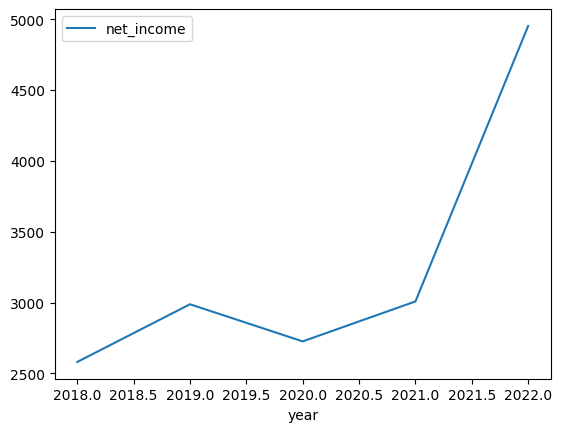

In [23]:
df.plot(x='year' , y='net_income')

In [26]:
t.net_income

4953

In [37]:
prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")

chain = prompt | chat

for s in chain.stream({"topic": "bears"}):
    print(s.content, end="", flush=True)

Why don't bears wear shoes?

Because they have bear feet!